# Analysis on the QM interaction patterns of MPro structures
We have seen that the QM description offered by large-scale DFT calculations enables us to provide a different characterization of the structures.


The base fragmentation of the dimer (monomer) have been found by inspecting the MD shapshots of the protein without the presence of the ligand nor the solvent molecules.

In [1]:
import yaml
from matplotlib import pyplot as plt
import seaborn as sns
from futile.Utils import file_list
from pandas import DataFrame, concat
from BigDFT import BioQM
from BigDFT.Stats import ClusterGrammer
from scipy.cluster import hierarchy as hc
from BigDFT.PostProcessing import systems_heatmap
from ase.units import Hartree, kcal, mol, kJ
factor = Hartree / (kJ/mol) #(kcal/mol)
dimer_view=yaml.load(open('dimer_view.yaml'))

In [2]:
def run_id(name):
    nm = name if '/' not in name else name.split('/')[1]
    spl = nm.split('_')
    # print (spl)
    substrate = spl[0]
    icluster = spl.index('cluster')
    try:
        snapshot = int(spl[icluster+1])
        kind = spl[icluster+2].split('-')[0]
    except Exception:
        snapshot = int(spl[icluster+1].replace('.tar.bz2','').split('-')[0])
        kind='runs'
    return substrate,kind,snapshot
def setdefault_multiple(d,*args):
    from futile.Utils import push_path
    tmp,key = push_path(d,*args[:-1])
    tmp[key] = args[-1]
    return d

In [3]:
files = []
for key in 'inhibitors','dimer','assembly':
    files += file_list('newruns',suffix=key+'-1.1.tar.bz2',include_directory_path=True)
data = {}
for tree, file in zip(map(run_id,files),files):
    path = list(tree)
    value = {'archive':file}
    setdefault_multiple(data,*(path+[value]))

In [4]:
pops={}
for kind in data:
    print (kind)
    pops[kind] = BioQM.BioSystemPopulation.load(kind+'_populations.tar.gz')

subs02


/home/genovese/binaries/client/install/lib/python3.6/site-packages/Bio/SeqIO/PdbIO.py:292: BiopythonParserWarning: 'HEADER' line not found; can't determine PDB ID.
  BiopythonParserWarning,


0:  # weight=1.0


/home/genovese/binaries/client/install/lib/python3.6/site-packages/Bio/SeqIO/PdbIO.py:292: BiopythonParserWarning: 'HEADER' line not found; can't determine PDB ID.
  BiopythonParserWarning,


  - bond_orders
  - interactions
  - electrostatic_interactions
  - system_dfs
subs05


/home/genovese/binaries/client/install/lib/python3.6/site-packages/Bio/SeqIO/PdbIO.py:292: BiopythonParserWarning: 'HEADER' line not found; can't determine PDB ID.
  BiopythonParserWarning,


0:  # weight=1.0


/home/genovese/binaries/client/install/lib/python3.6/site-packages/Bio/SeqIO/PdbIO.py:292: BiopythonParserWarning: 'HEADER' line not found; can't determine PDB ID.
  BiopythonParserWarning,


  - bond_orders
  - interactions
  - electrostatic_interactions
  - system_dfs
subs01


/home/genovese/binaries/client/install/lib/python3.6/site-packages/Bio/SeqIO/PdbIO.py:292: BiopythonParserWarning: 'HEADER' line not found; can't determine PDB ID.
  BiopythonParserWarning,


0:  # weight=1.0


/home/genovese/binaries/client/install/lib/python3.6/site-packages/Bio/SeqIO/PdbIO.py:292: BiopythonParserWarning: 'HEADER' line not found; can't determine PDB ID.
  BiopythonParserWarning,


  - bond_orders
  - interactions
  - electrostatic_interactions
  - system_dfs
subs13


/home/genovese/binaries/client/install/lib/python3.6/site-packages/Bio/SeqIO/PdbIO.py:292: BiopythonParserWarning: 'HEADER' line not found; can't determine PDB ID.
  BiopythonParserWarning,


0:  # weight=1.0


/home/genovese/binaries/client/install/lib/python3.6/site-packages/Bio/SeqIO/PdbIO.py:292: BiopythonParserWarning: 'HEADER' line not found; can't determine PDB ID.
  BiopythonParserWarning,


  - bond_orders
  - interactions
  - electrostatic_interactions
  - system_dfs


In [5]:
def determine_sort_order(sys,ct):
    st={}
    for fr in ct:
        ipos = sys.fragment_ids[fr]
        st[ipos] = fr
    return [st[f] for f in sorted(st)]
def overall_contact_region(pops,cutoff,criteria='bond_order'):
    all_contact_regions=[]
    for subs, sys in pops.items():
        contact, _=sys.identify_contact_region(sys.sequences_to_fragments[2],
                                               cutoff_bo=cutoff if criteria=='bond_order' else 1.e10,
                                               cutoff_el=1.e10 if criteria=='bond_order' else cutoff)
        all_contact_regions += [c for c in contact if c not in all_contact_regions and 'C-' not in c]
    return all_contact_regions
def substrate_fragment_name(res):
    from BigDFT.BioQM import rename_residue
    renamed = rename_residue(res)
    ch,idlett = renamed.split('-')
    ids,lett = idlett.split(':')
    shift={'A': 0, 'B': 0, 'C': -7}
    if ch == 'C':
        n=int(ids)+shift.get(ch,0)
        if n>=0: n+=1
        return 'P'+str(abs(n))+ ("'" if n > 0 else '')
    else:
        return res
def build_dataframe_of_contact_interactions(pop,substrate,contact):
    from BigDFT.Stats import Population,weighted_dataframe
    int_pop = Population(labels=contact)
    for df,w,l in zip(pop.datas,pop.weights,pop.sample_labels):
        fragments = list(df.columns)
        interactions = factor*BioQM.interaction_strengths(fragments, substrate, df)
        dt = {f:[interactions[fragments.index(f)]] for f in contact}
        int_pop.append(data=dt,weight=w,label=l)
    return weighted_dataframe(int_pop.datas,int_pop.weights)
def build_dataframe_of_substrate_interactions(pop,substrate):
    from BigDFT.Stats import Population,weighted_dataframe
    subsites = [substrate_fragment_name(f) for f in substrate]
    int_pop = Population(labels=subsites)
    for df,w,l in zip(pop.datas,pop.weights,pop.sample_labels):
        fragments = list(df.columns)
        interactions = factor*BioQM.interaction_strengths(fragments,
                                                          [f for f in fragments if f not in substrate], df)
        dt = {substrate_fragment_name(f):[interactions[fragments.index(f)]] for f in substrate}
        int_pop.append(data=dt,weight=w,label=l)
    return weighted_dataframe(int_pop.datas,int_pop.weights)
def contact_df_of_substrate(pops,contact,criteria='interactions'):
    substrate= pops.sequences_to_fragments[2]
    pop=pops.populations[criteria]
    df=build_dataframe_of_contact_interactions(pop,substrate,[c for c in contact if c not in substrate]) 
    sort=determine_sort_order(pops,contact)
    form = ['letter','num'] if criteria=='interactions' else ['ch','-','letter','num']
    return df[sort].rename(columns=pops.labeldict(fmt=form))
def contact_df_of_enzyme(pops,criteria='interactions'):
    substrate= pops.sequences_to_fragments[2]
    pop=pops.populations[criteria]
    df=build_dataframe_of_substrate_interactions(pop,substrate) 
    #sort=determine_sort_order(pops,substrate)
    #form = ['letter','num'] if criteria=='interactions' else ['ch','-','letter','num']
    return df #[sort].rename(columns=pops.labeldict(fmt=form))

In [6]:
def represent_interaction_and_feedback(sys,criteria):
    substrate = sys.sequences_to_fragments[2]
    data = sys.fragment_interaction_and_feedback(target=substrate,criteria=criteria)
    return {f: e for e,f in zip(data,sys.fragment_names)}

In [7]:
def relevant_violin_plots_substrates(pops,criteria='bond_order'):
    if criteria == 'electrostatic':
        recriteria = 'electrostatic_interactions'
    else:
        recriteria = 'interactions'
    alldf={subs: contact_df_of_enzyme(pops[subs],recriteria) for subs in pops}
    fig, axs = plt.subplots(4,1,figsize=(10,16))
    for subs,ax in zip(sorted(alldf),axs):
        #ax=alldf[subs].boxplot(ax=ax)
        ax=sns.violinplot(data=alldf[subs],ax=ax,cut=0)
        ax.set_xticklabels(ax.get_xticklabels(),rotation=90)
        ax.set_title(subs if subs != 'subs13' else 'pep13')
    fig.tight_layout()
    return alldf

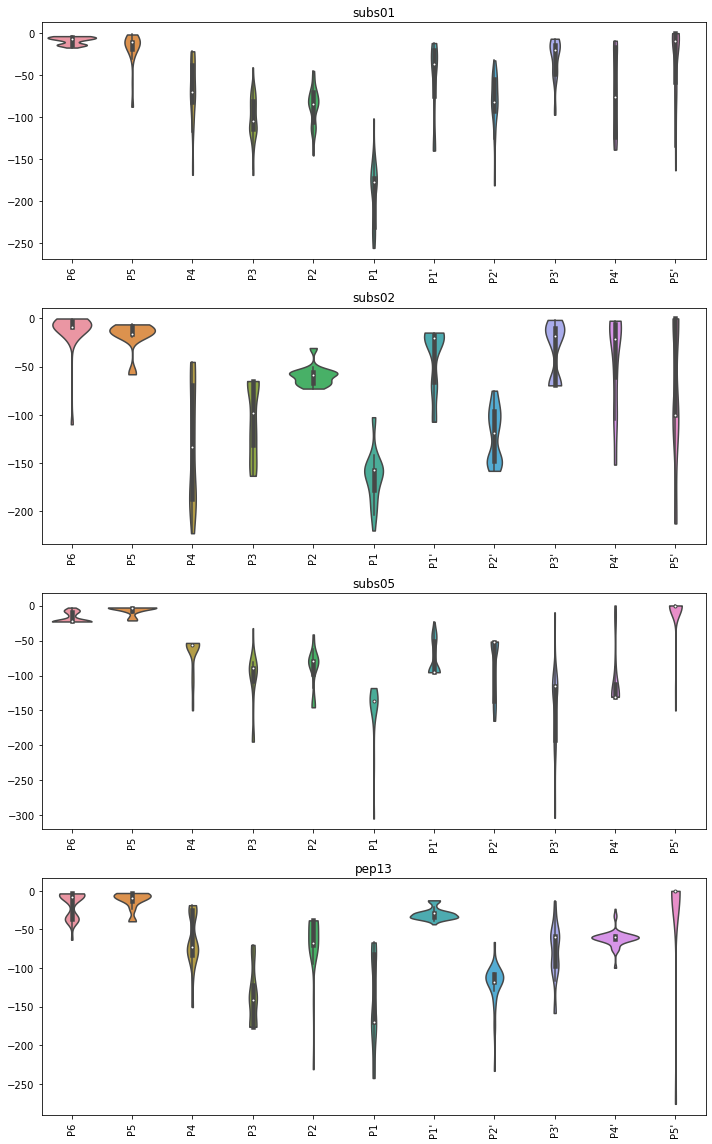

In [346]:
substrate_df=relevant_violin_plots_substrates(pops)

In [18]:
def relevant_violin_plots(pops,cutoff,criteria='bond_order'):
    ct=overall_contact_region(pops,cutoff,criteria)
    if criteria == 'electrostatic':
        recriteria = 'electrostatic_interactions'
    else:
        recriteria = 'interactions'
    alldf={subs: contact_df_of_substrate(pops[subs],ct,recriteria) for subs in pops}
    fig, axs = plt.subplots(4,1,figsize=(10,16))
    for subs,ax in zip(sorted(alldf),axs):
        #ax=alldf[subs].boxplot(ax=ax)
        ax=sns.violinplot(data=alldf[subs],ax=ax,cut=0)
        ax.set_xticklabels(ax.get_xticklabels(),rotation=90)
        ax.set_title(subs if subs != 'subs13' else 'pep13')
    fig.tight_layout()
    return ct
def average_heatmaps(pops,ct,data,cmap='viridis'):
    df = factor*DataFrame(data)
    sort=determine_sort_order(pops['subs01'],ct)
    lb = pops['subs01'].labeldict(fmt=['ch','-','letter','num'])
    relct = [lb[c] for c in sort]
    df=df.transpose()[sort].rename(columns=lb).transpose()
    return systems_heatmap(df,restrict_to=[relct],columns=sorted(df.columns),cmap=cmap)

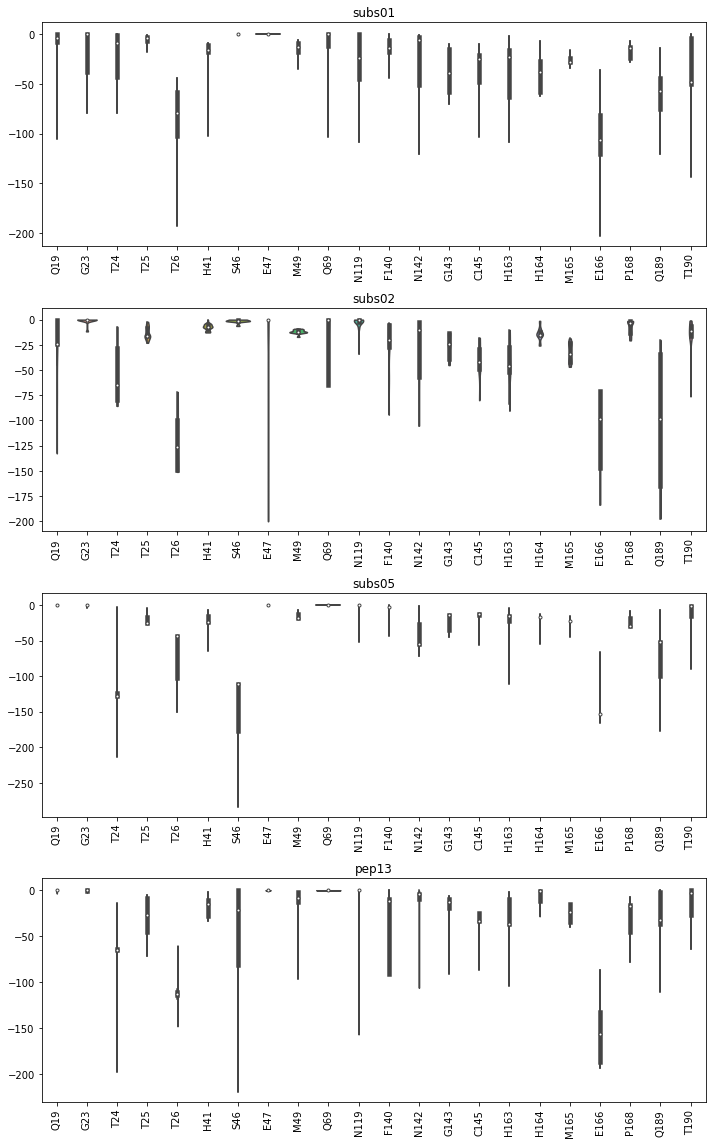

In [8]:
ct=relevant_violin_plots(pops,0.005)

In [17]:
from collections import OrderedDict
subs_contact=OrderedDict()
subs_electrostatic=OrderedDict()
for name,sys in pops.items():
    rename = name if name != 'subs13' else 'pep13'
    subs_contact[rename]=represent_interaction_and_feedback(sys,'hamiltonian')
    subs_electrostatic[rename]=represent_interaction_and_feedback(sys,'electrostatic')

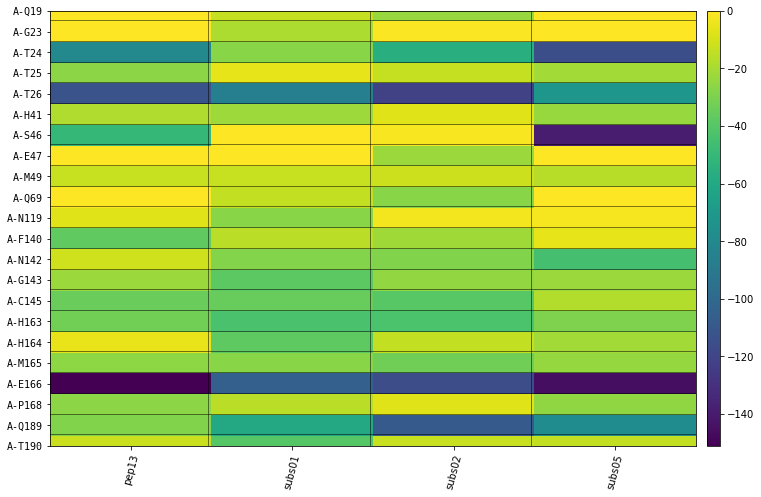

In [18]:
average_heatmaps(pops,ct,subs_contact)

In [308]:
def rename_fragment(res):
    from BigDFT.BioQM import rename_residue
    renamed = rename_residue(res)
    ch,idlett = renamed.split('-')
    ids,lett = idlett.split(':')
    shift={'A': 0, 'B': 0, 'C': -7}
    if ch == 'C':
        n=int(ids)+shift.get(ch,0)
        if n>=0: n+=1
        return '\n'.join([lett,'P'+str(abs(n))+ ("'" if n > 0 else '')])
    else:
        return '\n'.join([lett,str(int(ids)+shift.get(ch,0))])
def rotation(theta):
    from numpy import array, pi
    th = pi/180.0*theta
    return array(( (np.cos(th), -np.sin(th)),
                 (np.sin(th),  np.cos(th)) ))
def rotate_layout(layout,theta):
    R = rotation(theta)
    return {k: R.dot(v) for k, v in layout.items()}
def interaction_graph(sys,cutoff,ax=None,colorbar_label=None):
    subs_frag = sys.sequences_to_fragments[2]
    remap=list(map(rename_fragment,sys.fragment_names))
    interactions = sys.fragment_interaction_and_feedback(subs_frag,criteria='hamiltonian')
    ax=sys.display_graph(restrict_to=subs_frag,bo_cutoff=cutoff,fragment_labels=remap,
                         field_vals=factor*interactions,ax=ax,vmax=0,vmin=-45,
                         colorbar_label=colorbar_label)
    return ax
def interaction_graph_fixed_layout(sys,cutoff,ax=None,colorbar_label=None,fixed_layout=None,k=0.2,theta=-45):
    from BigDFT.Visualization import get_colordict
    from numpy import log10
    def fixed_node_name(n):
        f = sys.fragment_names[n]
        rename = rename_fragment(f)
        return rename.split('\n')[1]
    subs_frag = sys.sequences_to_fragments[2]
    remap=list(map(rename_fragment,sys.fragment_names))
    interactions = sys.fragment_interaction_and_feedback(subs_frag,criteria='hamiltonian')
    G=BioQM.Graph(restrict_to=subs_frag,bond_orders=sys.bond_orders,cutoff=cutoff,
                  fragkeys=sys.fragment_names,frag_labels=remap)
    colord=get_colordict(sys.fragment_names,field_vals=factor*interactions,vmin=-185,
                         colorcode='viridis',center_cmap=False)
    colors=[colord[f] for f in sys.fragment_names]
    layout = rotate_layout(nx.kamada_kawai_layout(G.nw),theta=theta)
#     final_layout=layout
    relayout=[]
    if fixed_layout is None:
        for node in layout:
            f = sys.fragment_names[node]
            if f in subs_frag:
                relayout.append(node)
    else:
        for node in layout:
            rename = fixed_node_name(node)
            if rename in fixed_layout:
                relayout.append(node)
                layout[node] = fixed_layout[rename]
    final_layout = nx.spring_layout(G.nw,pos=layout,fixed=relayout,k=k,seed=2)
    edge_colord = G.edge_colordict(colorcode='copper_r',
                                   field_vals=log10(G.edge_weights),center_cmap=False)
    G.display(layout=final_layout,colors=colors,axs=ax,colorbar_label=colorbar_label,
              colorbar_mappable=colord.get('__mappable__') if colorbar_label is not None else None,
              font_weight='normal',font_family='sans-serif',node_size=1000,font_size=16,
              edge_colors=edge_colord,edge_legend=False)
    return [{fixed_node_name(n):final_layout[n] for n in relayout},
            colord.get('__mappable__'),edge_colord.get('__mappable__')]

In [309]:
from importlib import reload
reload(BioQM)
from BigDFT import Visualization as V
reload(V)

<module 'BigDFT.Visualization' from '/home/genovese/binaries/client/install/lib/python3.6/site-packages/BigDFT/Visualization.py'>

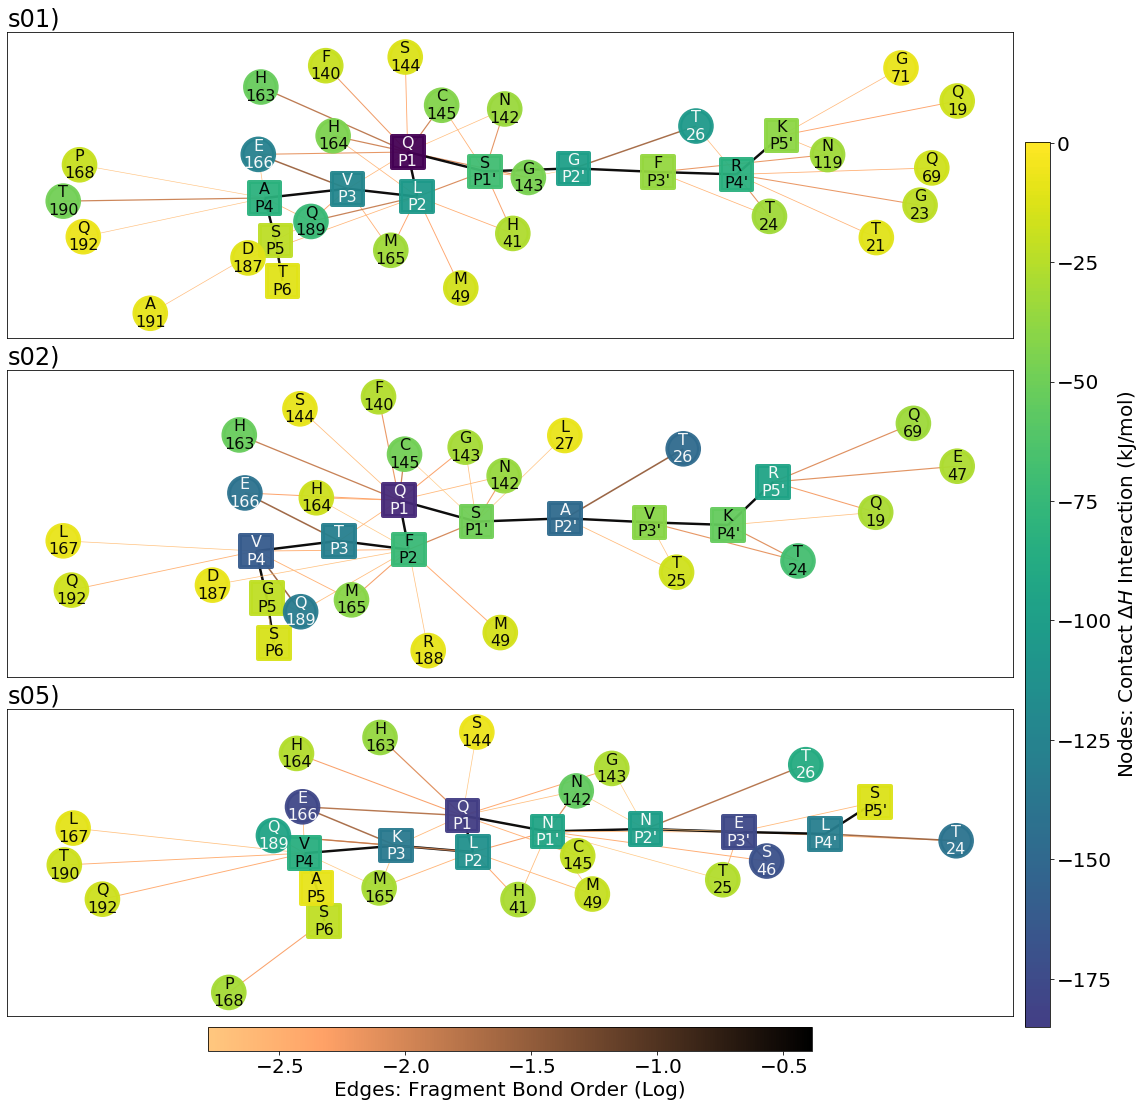

In [330]:
from matplotlib.ticker import ScalarFormatter
colorbar_title='Nodes: Contact $\Delta H$ Interaction (kJ/mol)'
edge_colorbar_title='Edges: Fragment Bond Order (Log)'
fig, axs = plt.subplots(3,1,figsize=(16,16))
fixed_layout=None
for subs,ax in zip(sorted(pops),axs.flatten()):
    if subs == 'subs13': continue
    fixed_layout,mappable,edge_mappable=interaction_graph_fixed_layout(pops[subs],0.005,ax,
                                                #colorbar_label=colorbar_title,
                                                fixed_layout=fixed_layout,k=0.22 if subs != 'subs05' else 0.25)
    ax.set_title('s'+subs[4:]+')',fontsize=24, loc='left')
# Now adding the colorbar
fig.tight_layout()
cb=fig.colorbar(mappable,ax=axs,pad=0.01,fraction=0.1,aspect=35,shrink=0.8) #,anchor=(1.0,0.5))
cb.set_label(label=colorbar_title,size=20)
for t in cb.ax.get_yticklabels():
     t.set_fontsize(20)
ecb=fig.colorbar(edge_mappable,ax=axs,pad=0.01,fraction=0.1,aspect=25,shrink=0.6,
                 format=ScalarFormatter(useMathText=True),orientation='horizontal') #,anchor=(1.0,0.0))
for t in ecb.ax.get_xticklabels():
     t.set_fontsize(20)
ecb.set_label(label=edge_colorbar_title,size=20)


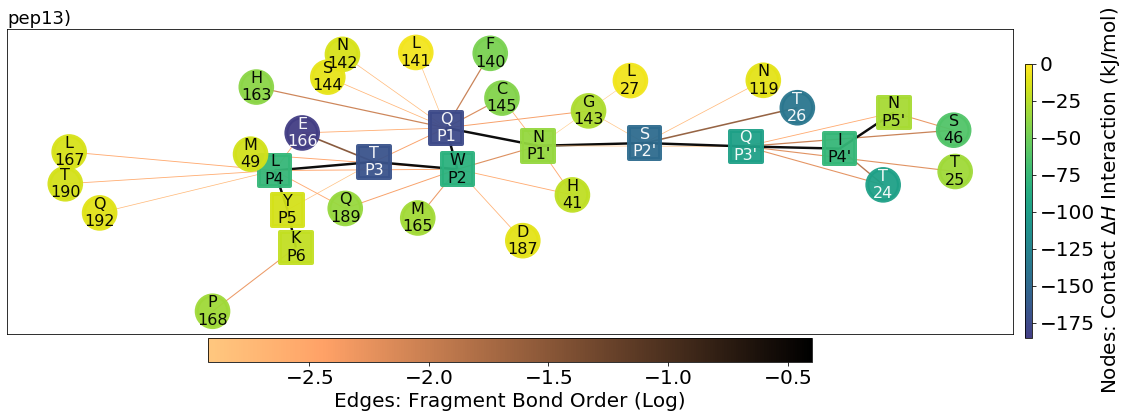

In [331]:
fig, ax = plt.subplots(1,1,figsize=(16,16/3))
subs='subs13'
_,_,edge_mappable=interaction_graph_fixed_layout(pops[subs],0.005,ax=ax,fixed_layout=fixed_layout)
ax.set_title('pep13)',loc='left',size=18)
fig.tight_layout()
cb=fig.colorbar(mappable,ax=ax,pad=0.01,fraction=0.1,aspect=35,shrink=0.8) #,anchor=(1.0,0.5))
cb.set_label(label=colorbar_title,size=20)
for t in cb.ax.get_yticklabels():
     t.set_fontsize(20)
ecb=fig.colorbar(edge_mappable,ax=ax,pad=0.01,fraction=0.1,aspect=25,shrink=0.6,
                 format=ScalarFormatter(useMathText=True),orientation='horizontal') #,anchor=(1.0,0.0))
for t in ecb.ax.get_xticklabels():
     t.set_fontsize(20)
ecb.set_label(label=edge_colorbar_title,size=20)

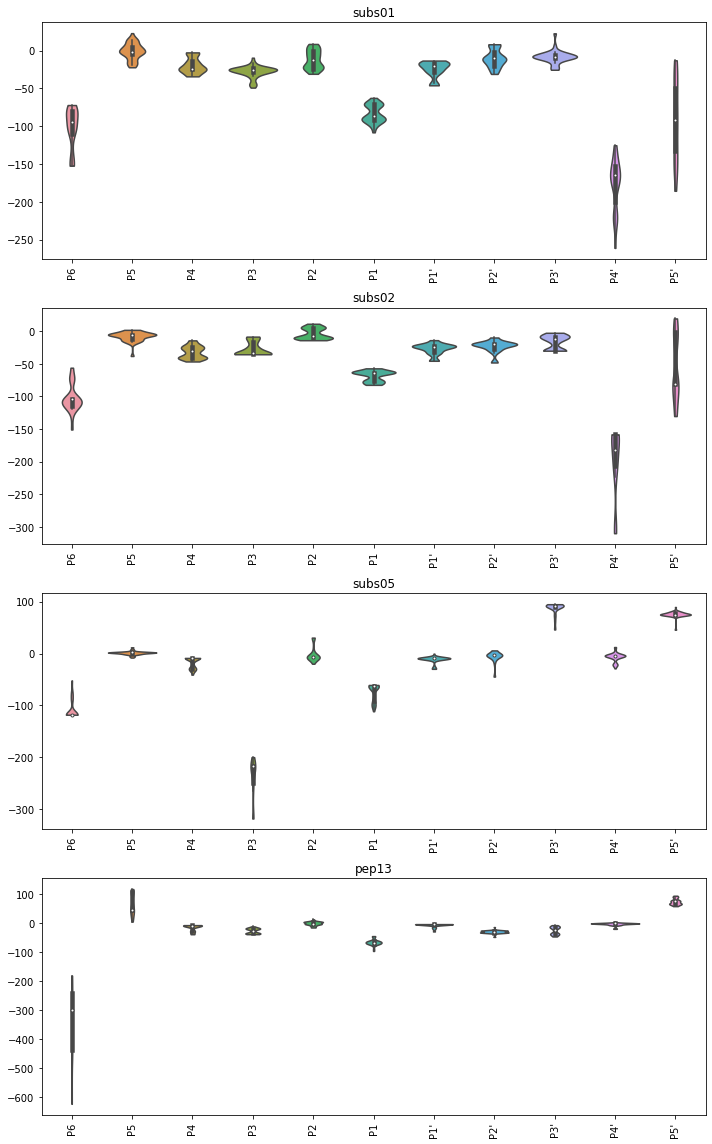

In [347]:
substrate_df_el=relevant_violin_plots_substrates(pops,'electrostatic')

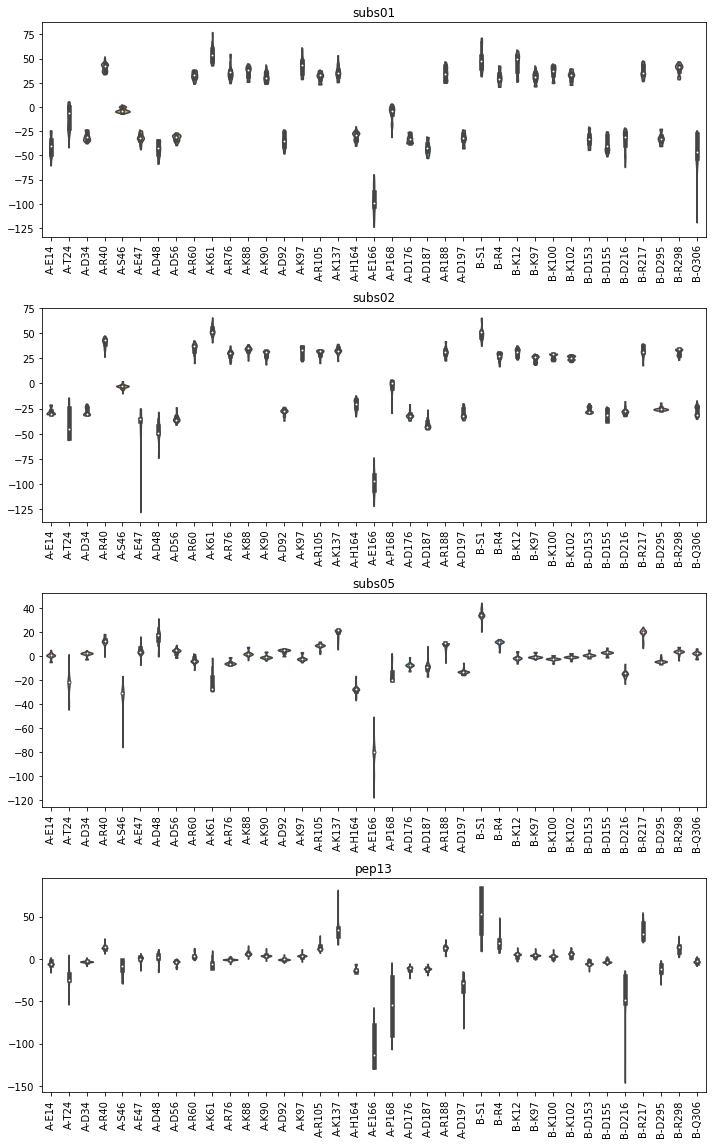

In [23]:
ct_el=relevant_violin_plots(pops,30.0/factor,'electrostatic')

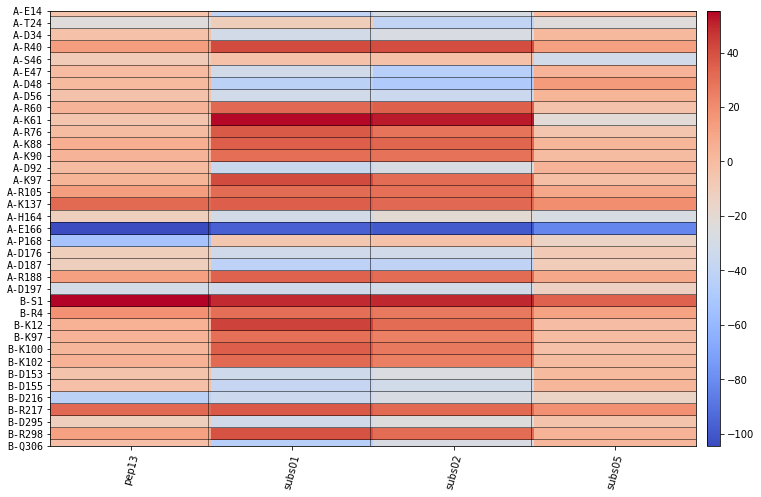

In [24]:
average_heatmaps(pops,ct_el,subs_electrostatic,'coolwarm')

# Comparison of the MD trajectories energies

In [14]:
def interaction_strengths_no_sol(fragments, target_fragments, pairwise_bo):
    """
    Define the interaction strengths of the fragment list with the
    others with respect to a set of target fragments

    Args:
        fragments (list) : the name of the fragments of the
            system in pairwise_bo
        target_fragments (list) : the fragments constituting the target region
        pairwise_bo (dict): the bond order between fragments

    Returns:
        array: the  sum of the weigths of the interactions of the fragments
            in the target region
    """
    import numpy as np
    lookup = [fragments.index(frag) for frag in target_fragments]
    BOtot = np.zeros(len(fragments))
    for ipair in lookup:
        frag_i = fragments[ipair]
        BOtot += np.array([0.5* (pairwise_bo[frag_i][frag] + pairwise_bo[frag][frag_i]) if 'SOL' not in frag else 0.0 for frag in fragments ])
        #BOtot += np.array([pairwise_bo[frag_i][frag] + pairwise_bo[frag][frag_i] for frag in fragments])
    if len(lookup) > 0:
        BOtot[np.array(lookup)] = np.nan
    return BOtot
def interaction_on_target(pp,target,name,contact_region):
    from numpy import isnan
    from ase.units import Hartree, kcal, mol
    from BigDFT.Stats import clean_dataframe
    factor = Hartree / (kcal/mol)
    tgti={}
    for k,d,w in zip(pp.sample_labels,pp.datas,pp.weights):
        dd=clean_dataframe(d).to_dict()
        fragment_names = list(pp.feature_labels)
        #ints=BioQM.interaction_strengths(fragment_names,target,dd)
        ints=interaction_strengths_no_sol(fragment_names,target,dd)
        tot_int = factor*sum(t for t in ints if not isnan(t))
        if int(k) not in tgti:
            tgti[int(k)]={}
        tgti[int(k)][name]=tot_int
        tgti[int(k)][name+'-weight']=w
        if contact_region is None: continue
        cr_int = factor*sum(t for t,n in zip(ints,fragment_names) if not isnan(t) and n in contact_region)
        tgti[int(k)][name+'-contact']=cr_int
    return tgti
def fragmented_interactions(pop,cr):
    from pandas import DataFrame
    from futile.Utils import dict_merge
    all_fi=[]
    for name in ['interactions','electrostatic_interactions','electrostatic']:
        if name not in pop.populations: continue
        all_fi.append(interaction_on_target(pop.populations[name],pop.sequences_to_fragments[2],name,cr))
    if len(all_fi) == 2: dict_merge(dest=all_fi[0],src=all_fi[1])
    all_fi=all_fi[0]
    return DataFrame(all_fi).transpose()
def interaction_energies(pop):
    from pandas import DataFrame
    pp=pop.populations['energies']
    eints={}
    for k,v,w in zip(pp.sample_labels,pp.datas,pp.weights):
        eints[int(k)]={kk: vv[0] for kk,vv in v.to_dict().items()}
        eints[int(k)]['weights']=w
    return DataFrame(eints).transpose()
def polaris_interactions(filename,sheet):
    from pandas import read_excel
    tt = read_excel(filename,header=1,index_col=0,sheet_name=sheet)
    return tt[[ '∆U',  '∆U.1']].rename(columns=lambda x: 'Polaris'+('-vdW' if '.1' in x else ''))
def substrate_interaction_energies(name,pops,cr):
    from pandas import DataFrame
    tt1=interaction_energies(pops[name])
    tt2=polaris_interactions('data_substrats_oxford_polaris.xlsx',name.replace('subs','substrat_'))
    tt3=fragmented_interactions(pops[name],cr)
    wgts = {'Tot.Weights':{i+1:w for i,w in enumerate(pops[name].populations['charge'].weights)}}
    d1=tt1.to_dict()
    d2=tt2.to_dict()
    d3=tt3.to_dict()
    d2.update(d1)
    d2.update(wgts)
    d2.update(d3)
    return DataFrame(d2)
def weight_av(df,keys,wgtkey):
    from numpy import sqrt
    wa={}
    wgt=df[wgtkey]
    for key in keys:
        etot = df[key]
        emean = (wgt*etot).sum()/wgt.sum()
        std = sqrt((wgt*etot**2).sum()/wgt.sum()-emean**2)
        wa[key]=(emean,std)
    return wa
def weighted_avgs(df):
    wa={}
    if 'weights' in df:
        wa.update(weight_av(df,['Tot','QM','vdW','OMM','E_el-app'],'weights'))
        wa.update(weight_av(df,['Polaris','Polaris-vdW'],'Tot.Weights'))
    wa.update(weight_av(df,[i for i in df.columns 
                            if 'approx' in i or 'electrostatic' in i or 'interactions' in i],
                        'interactions-weight'))
    
    return wa
def plain_avgs(df):
    pa={}
    dfa=df.describe()
    for key in df.columns:
        if 'eight' in key: continue
        pa[key]=(dfa[key]['mean'],dfa[key]['std'])
    return pa
def extract_averages(dfs):
    tot_avgs={'weighted':{},'plain':{}}
    for key in dfs:
        df = dfs[key]
        #df['QM-approx']=0.5*(df['interactions']+df['electrostatic'])
        #df['QM-approx1']=df['interactions']
        #df['QM-approx2']=0.25*df['interactions']+0.5*df['electrostatic']
        #df['QM-approx3']=0.5*df['electrostatic']
        #reorder_avgs(tot_avgs['weighted'],weighted_avgs(df))
        #reorder_avgs(tot_avgs['plain'],plainweighted_avgs(df))
        for k, val in weighted_avgs(df).items():
            tot_avgs['weighted'].setdefault(k,{}).setdefault(key,val[0])
            tot_avgs['weighted'].setdefault(k+'-std',{}).setdefault(key,val[1])
        for k, val in plain_avgs(df).items():
            tot_avgs['plain'].setdefault(k,{}).setdefault(key,val[0])
            tot_avgs['plain'].setdefault(k+'-std',{}).setdefault(key,val[1])
    return tot_avgs
def scatterplot(dfs,kind,x,y,ax=None):
    colors={'subs01':'blue','subs02':'red','subs05':'green','subs13':'orange'}
    df = dfs[kind]
    cols = [colors[i] for i in df.index] 
    return df.plot.scatter(x=x,y=y,xerr=x+'-std',yerr=y+'-std',c=cols,linewidths=5,ax=ax)

In [15]:
full_dfs={key: substrate_interaction_energies(key,pops,None) for key in pops}
dfs={kind: DataFrame(extract_averages(full_dfs)[kind]) for kind in ['plain','weighted']}

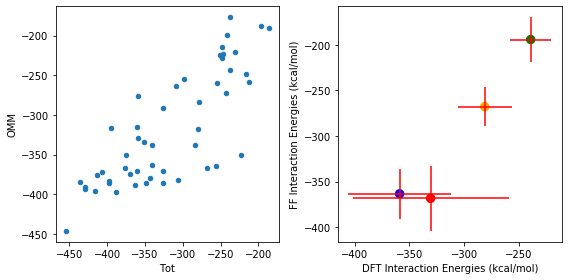

In [17]:
fig,axs=plt.subplots(1,2,figsize=(8,4))
concat(full_dfs.values()).plot.scatter(x='Tot',y='OMM',ax=axs[0])
scatterplot(dfs,'weighted','Tot','OMM',ax=axs[1])
axs[1].set_xlabel('DFT Interaction Energies (kcal/mol)')
axs[1].set_ylabel('FF Interaction Energies (kcal/mol)')
fig.tight_layout()

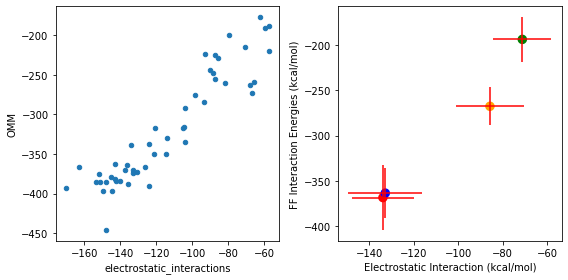

In [18]:
fig,axs=plt.subplots(1,2,figsize=(8,4))
concat(full_dfs.values()).plot.scatter(y='OMM',x='electrostatic_interactions',ax=axs[0])
scatterplot(dfs,'weighted','electrostatic_interactions','OMM',ax=axs[1])
axs[1].set_xlabel('Electrostatic Interaction (kcal/mol)')
axs[1].set_ylabel('FF Interaction Energies (kcal/mol)')
fig.tight_layout()

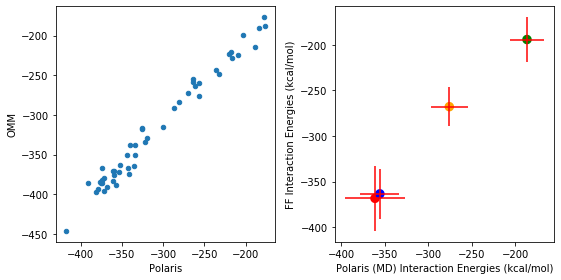

In [19]:
fig,axs=plt.subplots(1,2,figsize=(8,4))
concat(full_dfs.values()).plot.scatter(y='OMM',x='Polaris',ax=axs[0])
scatterplot(dfs,'weighted','Polaris','OMM',ax=axs[1])
axs[1].set_xlabel('Polaris (MD) Interaction Energies (kcal/mol)')
axs[1].set_ylabel('FF Interaction Energies (kcal/mol)')
fig.tight_layout()

# Data of the XChem fragment analysis

In [357]:
XChem = BioQM.BioSystemPopulation.load('XChem-populations.tar.gz',options=dict(sequence_from_fragments=True,disable_warnings=True))

/home/genovese/binaries/client/install/lib/python3.6/site-packages/BigDFT/BioQM.py:680: UserWarning: Some atoms were not matchedUnable to match atom{'sym': 'H', 'r': [6.351, -3.914, 22.4], 'name': 'H', 'units': 'angstroem'}
  warn('Some atoms were not matched' + str(e))


0:  # weight=1.0


/home/genovese/binaries/client/install/lib/python3.6/site-packages/BigDFT/BioQM.py:680: UserWarning: Some atoms were not matchedUnable to match atom{'sym': 'H', 'r': [6.351, -3.914, 22.4], 'name': 'H', 'units': 'angstroem'}
  warn('Some atoms were not matched' + str(e))


  - bond_orders
  - interactions
  - electrostatic_interactions
  - system_dfs


In [379]:
from BigDFT import Systems as S, PostProcessing as P, Atoms as A
reload(S)
reload(P)
reload(A)
reload(BioQM)

<module 'BigDFT.BioQM' from '/home/genovese/binaries/client/install/lib/python3.6/site-packages/BigDFT/BioQM.py'>

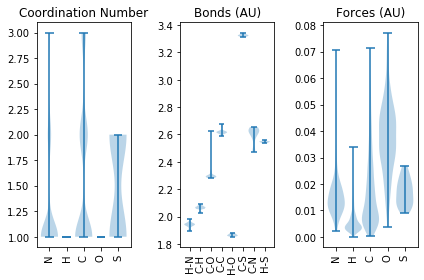

In [361]:
_=XChem.examine()

In [19]:
def load_from_serialized_dict(atdict, preserve_keys=[]):
    from BigDFT.Atoms import Atom
    raw_keys = ['qel_0'] + preserve_keys
    xyz = ['x', 'y', 'z']
    newdict = {}
    reworked_keys = set()
    for key, val in atdict.items():
        if '_' not in key or key in raw_keys:
            newdict[key] = val
            continue
        if 'coord' in key:
            ipos = xyz.index(key.split('_')[0])
            newkey = 'r'
        else:
            newkey, ipos = key.split('_')
        reworked_keys.add(newkey)
        newdict.setdefault(newkey, {}).setdefault(int(ipos), val)
    for key in reworked_keys:
        newval = [newdict[key][ipos] for ipos in sorted(list(newdict[key].keys()))]
        newdict[key] = newval
    return Atom(newdict)
        
def system_from_df(df):
    from BigDFT.Systems import System
    from BigDFT.Fragments import Fragment
    
    dft = df.transpose()
    sys=System()
    for at in dft:
        atdict = dft[at].to_dict()
        frag = atdict.pop('frag')
        at = load_from_serialized_dict(atdict)
        sys.setdefault(frag,Fragment()).append(at)
    return sys

Reconstitute the population data as they are supposed to be defined

In [374]:
def new_populations(populations):
    from BigDFT.Stats import Population
    from BigDFT.Systems import system_from_df
    oldpop = populations['system_dfs']
    pop_sys = Population(labels=oldpop.feature_labels)
    pop_el = Population(labels=oldpop.feature_labels)
    for df,w,l in zip(oldpop.datas,oldpop.weights,oldpop.sample_labels):
        sys=system_from_df(df)
        pop_sys.append(data=sys.df,weight=w,label=l)
        pop_el.append(data=sys.electrostatic_interactions,weight=w,label=l)
    return pop_sys,pop_el

In [375]:
pop_sys, pop_el = new_populations(XChem.populations)

ValueError: could not convert string to float: 'N'

In [376]:
df=XChem.populations['system_dfs'].datas[0]

In [377]:
sys=system_from_df(df)

In [378]:
sys['A-SER:1'][0].store

{'force_0': 0.003471333436862,
 'force_1': -0.003640413109496,
 'force_2': -0.007194677727088,
 'multipole character': 'net',
 'name': 'N',
 'q0_0': -0.16403799999999968,
 'q1_0': 0.1171047,
 'q1_1': 0.1111218,
 'q1_2': -0.05912271,
 'q2_0': -0.4372705,
 'q2_1': -0.5500069,
 'q2_2': 0.2742531,
 'q2_3': -0.1499954,
 'q2_4': -0.1655729,
 'sigma_0': 0.284,
 'sigma_1': 0.284,
 'sigma_2': 0.284,
 'sym': 'N',
 'units': 'angstroem',
 'x_coord': -1.22076307646903,
 'y_coord': 12.678172569707,
 'z_coord': -28.89958162297349,
 'nzion': 5.0,
 'qel_0': -5.164038}

In [367]:
system_from_df(df)

In [383]:
def sample_interaction_and_feedback(fragments,target,data):
    from numpy import isnan, array
    interactions = BioQM.interaction_strengths(fragments, target, data)
    environment = [f for f in fragments if f not in target]
    feedback = BioQM.interaction_strengths(fragments, environment, data)
    assert abs(sum(interactions[~isnan(interactions)])-sum(
            feedback[~isnan(feedback)])) < 1.e-4
    return array([f if frag in target else i for i, f, frag in zip(
                interactions, feedback, fragments)])
from BigDFT.Systems import system_from_df
from BigDFT.BioQM import _interaction_and_feedback
new_electrostatic = {}
new_contact = {}
pop_sys = XChem.populations['system_dfs']
for lb,df,ct in zip(pop_sys.sample_labels,pop_sys.datas,XChem.populations['interactions'].datas):
    print (lb)
    sys=system_from_df(df)
    target = [f for f in sys if 'LIG' in f]
    fragments=list(sys)
    el=sys.electrostatic_interactions
    elec = sample_interaction_and_feedback(fragments,target,el)
    contact= sample_interaction_and_feedback(fragments,target,ct)    
    new_electrostatic[lb] = {f: e for e,f in zip(elec,fragments)}
    new_contact[lb] = {f: e for e,f in zip(contact,fragments)}    

x1392
x1412
x0705
x1418
x0708
x0426
x0425
x0387
x1093
x0305
x1308
x1012
x1493
x0540
x0946
x1119
x1402
x1351
x0736
x0734
x0731
x0434
x1086
x1101-1
x1101-0
x1002
x0336
x0771
x1311
x0830
x0831
x1249
x0689
x0195
x0194
x1425
x1132
x1336
x0759
x0755
x0752
x1235
x0350
x1237
x0354
x0692
x0991
x0995
x0669
x1458
x0749
x1348
x1187
x0464
x1226
x1334
x0678
x0104
x0376
x0107
x0786
x1358
x0770
x0774
x0478
x0874
x0390
x0978
x0769
x1077
x1478
x0177
x0072
x0981
x1163
x1385
x1384
x1386
x1380
x1382
x0887
x0499
x0967
x0161
x0398
x0165
x0395
x0397
x1374
x1375
x0691
x0820


In [23]:
new_contact = {}
for lb,df,el in zip(pop_sys.sample_labels,pop_sys.datas,XChem.populations['interactions'].datas):
    print (lb)
    sys=system_from_df(df)
    target = [f for f in sys if 'LIG' in f]
    fragments=list(sys)
    contact= sample_interaction_and_feedback(fragments,target,el)
    new_contact[lb] = {f: e for e,f in zip(contact,fragments)}

x1392
x1412
x0705
x1418
x0708
x0426
x0425
x0387
x1093
x0305
x1308
x1012
x1493
x0540
x0946
x1119
x1402
x1351
x0736
x0734
x0731
x0434
x1086
x1101-1
x1101-0
x1002
x0336
x0771
x1311
x0830
x0831
x1249
x0689
x0195
x0194
x1425
x1132
x1336
x0759
x0755
x0752
x1235
x0350
x1237
x0354
x0692
x0991
x0995
x0669
x1458
x0749
x1348
x1187
x0464
x1226
x1334
x0678
x0104
x0376
x0107
x0786
x1358
x0770
x0774
x0478
x0874
x0390
x0978
x0769
x1077
x1478
x0177
x0072
x0981
x1163
x1385
x1384
x1386
x1380
x1382
x0887
x0499
x0967
x0161
x0398
x0165
x0395
x0397
x1374
x1375
x0691
x0820


In [384]:
def represent_interaction_and_feedback(sys,criteria):
    substrate = sys.sequences_to_fragments[2]
    data = sys.fragment_interaction_and_feedback(target=substrate,criteria=criteria)
    return {f: e for e,f in zip(data,sys.fragment_names)}
for name,sys in pops.items():
    new_contact[name]=represent_interaction_and_feedback(sys,'hamiltonian')
    new_electrostatic[name]=represent_interaction_and_feedback(sys,'electrostatic')


In [385]:
el_df = DataFrame(new_electrostatic)
ct_df = DataFrame(new_contact)

In [97]:
cg=ClusterGrammer(el_df.dropna().rename(index=BioQM.rename_residue))

In [98]:
cg.show()

/usr/local/lib/python3.6/dist-packages/clustergrammer_widget/clustergrammer/run_filter.py:74: FutureWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ix-indexer-is-deprecated
  df = df.ix[keep_rows]
/usr/local/lib/python3.6/dist-packages/clustergrammer_widget/clustergrammer/make_views.py:28: FutureWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ix-indexer-is-deprecated
  tmp_df['mat'] = tmp_df['mat'].ix[keep_rows]


clustergrammer_widget(network='{"row_nodes": [{"name": "A-116:A", "ini": 301, "clust": 32, "rank": 63, "rankva…

In [99]:
#link=cg.publish('electrostatic_interactions_subs_XChem')

In [102]:
cg.publish_link()

'http://maayanlab.cloud/clustergrammer/viz/603f624cd0867e01721c47e5/electrostatic_interactions_subs_XChem.tsv'

In [396]:
cluster5='x0107, x0434, x0540, x0678, x0967'.split(', ')
contact_clusters = 'x0426, x1093, x0540, x0946, x0434, x0195, x0995, x0678, x0104, x0107, x0874, x1077, x0967, x0161, x0397, subs02, subs05, subs01, subs13'.split(', ')
el_clusters = 'x0387, x0752, x0354'.split(', ')

In [397]:
contact_clusters = [c for c in contact_clusters if c not in cluster5]

In [411]:
def color_labels(ax,cluster5,contact_clusters,el_clusters):
    ylabs=ax.get_yticklabels()
    for lab in ylabs:
        if lab.get_text() in cluster5:
            lab.set_color('red')
            lab.set_fontweight('bold')
        elif lab.get_text() in contact_clusters:
            lab.set_color('red')
        elif lab.get_text() in el_clusters:
            lab.set_color('purple')



In [412]:
from BigDFT.Stats import dataframe_dendrogram

Text(0.5, 0, 'Average Correlation Distance of Residue Contact Interactions with the ligand')

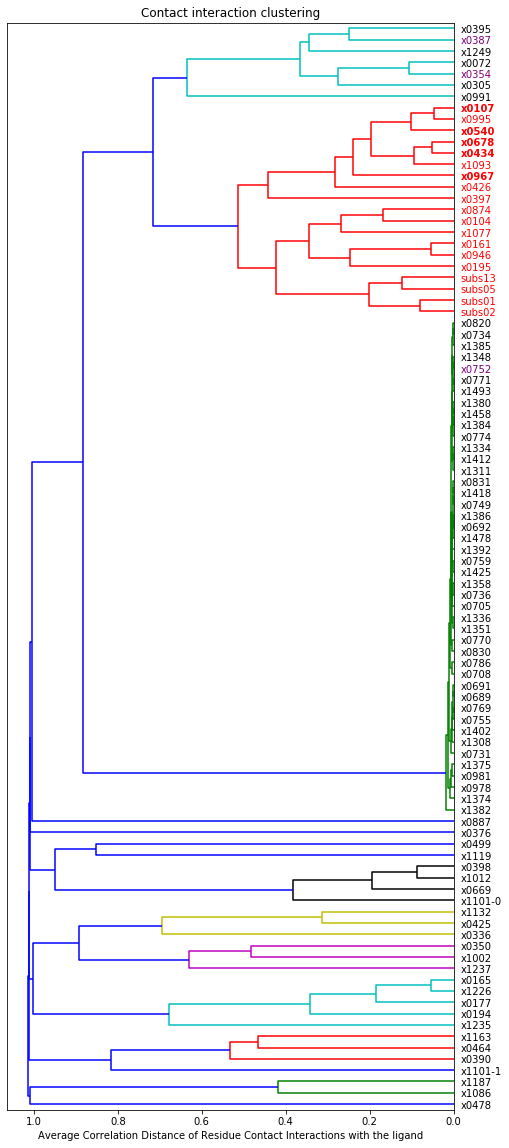

In [420]:
fig,ax = plt.subplots(figsize=(8,20))
contact_dendrogram=dataframe_dendrogram(ct_df.dropna(),orientation='left',ax=ax)
color_labels(ax,cluster5,contact_clusters,el_clusters)
ax.set_title('Contact interaction clustering')
ax.set_yticklabels(ax.get_yticklabels(),fontsize=10)
ax.set_xlabel('Average Correlation Distance of Residue Contact Interactions with the ligand')

Text(0.5, 0, 'Average Correlation Distance of Residue Electrostatic Interactions with the Ligand')

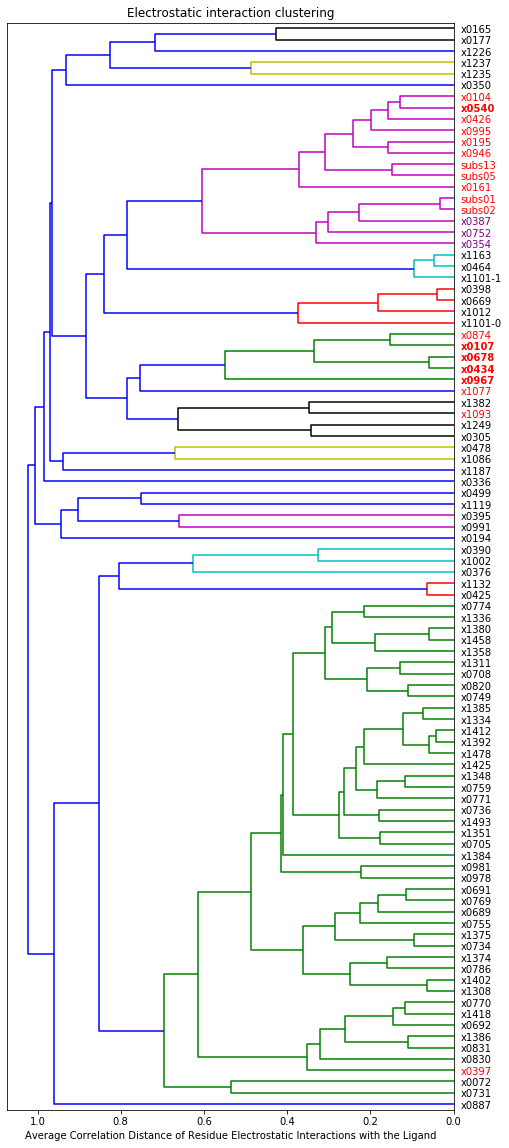

In [418]:
fig,ax = plt.subplots(figsize=(8,20))
contact_dendrogram=dataframe_dendrogram(el_df.dropna(),orientation='left',ax=ax)
color_labels(ax,cluster5,contact_clusters,el_clusters)
ax.set_title('Electrostatic interaction clustering')
ax.set_yticklabels(ax.get_yticklabels(),fontsize=10)
ax.set_xlabel('Average Correlation Distance of Residue Electrostatic Interactions with the Ligand')

In [423]:
pops['subs01'].populations['energies'].datas

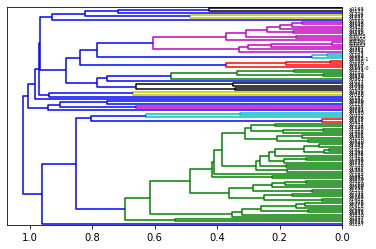

In [389]:
long_range_dendrogram=dataframe_dendrogram(el_df.dropna(),orientation='left')

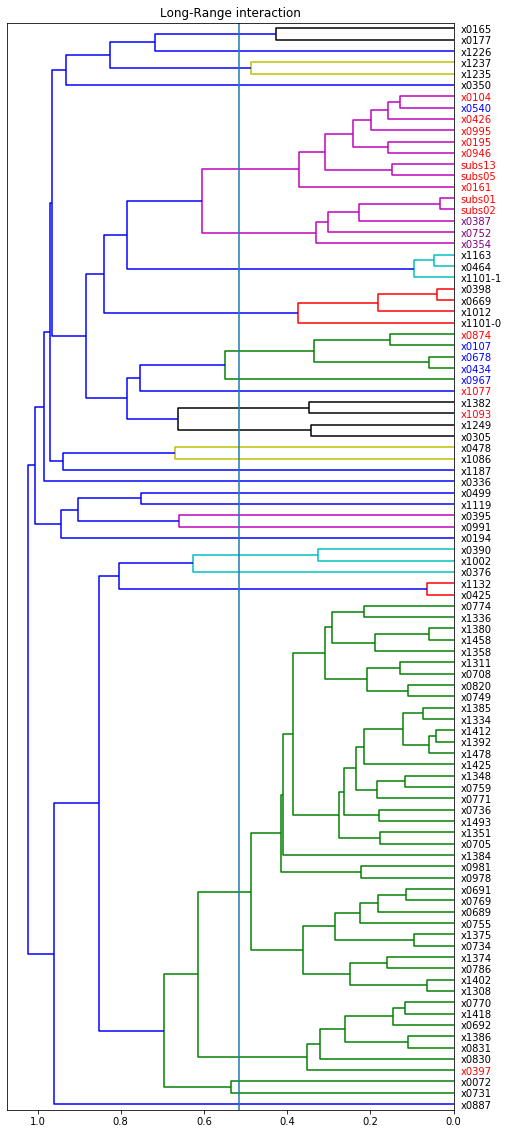

In [147]:
dataframe=(el_df).dropna()
z = hc.linkage(dataframe.values.T, method='average', metric='correlation')
fig,ax = plt.subplots(figsize=(8,20))
dendrogram = hc.dendrogram(z, labels=dataframe.columns, ax= ax, orientation='left')
ax.axvline(0.515)
color_labels(ax,cluster5,contact_clusters,el_clusters)
ax.set_title('Long-Range interaction')
_=ax.set_yticklabels(ax.get_yticklabels(),fontsize=10)

In [103]:
ct_cg=ClusterGrammer(ct_df.dropna().rename(index=BioQM.rename_residue))

In [104]:
ct_cg.show()

/usr/local/lib/python3.6/dist-packages/clustergrammer_widget/clustergrammer/run_filter.py:74: FutureWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ix-indexer-is-deprecated
  df = df.ix[keep_rows]
/usr/local/lib/python3.6/dist-packages/clustergrammer_widget/clustergrammer/make_views.py:28: FutureWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ix-indexer-is-deprecated
  tmp_df['mat'] = tmp_df['mat'].ix[keep_rows]


clustergrammer_widget(network='{"row_nodes": [{"name": "A-003:F", "ini": 144, "clust": 129, "rank": 134, "rank…

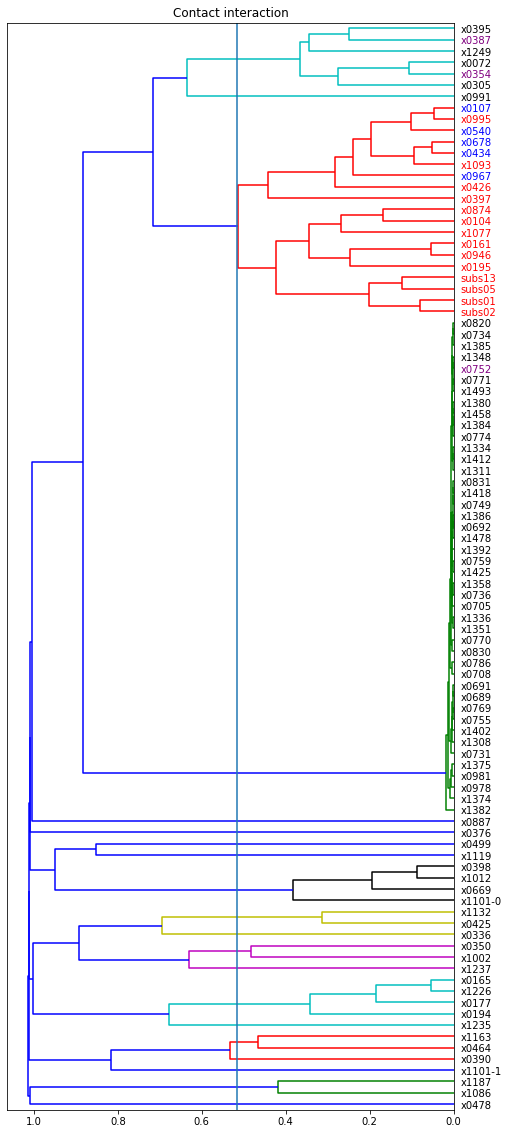

In [148]:
dataframe=(ct_df).dropna()
z = hc.linkage(dataframe.values.T, method='average', metric='correlation')
fig,ax = plt.subplots(figsize=(8,20))
dendrogram = hc.dendrogram(z, labels=dataframe.columns, ax= ax, orientation='left')
ax.axvline(0.515)
color_labels(ax,cluster5,contact_clusters,el_clusters)
ax.set_title('Contact interaction')
_=ax.set_yticklabels(ax.get_yticklabels(),fontsize=10)


In [108]:
#ct_cg.publish('contact_interactions_subs_XChem')

In [109]:
ct_cg.publish_link()

'http://maayanlab.cloud/clustergrammer/viz/603f6484d0867e01721c4820/contact_interactions_subs_XChem.tsv'